 ## Урок 3

### Домашнее задание

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р
4. Сделать выводы о том, какая модель справилась с задачей лучше других
5. *Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р

### Импорт необходимых библиотек

In [1]:
import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import itertools # Импорт модуля itertools для работы с итерируемыми объектами

import seaborn as sns   # Импорт библиотеки Seaborn для визуализации данных
import matplotlib.pyplot as plt # Импортируем библиотеку matplotlib.pyplot для построения графиков

# Импортируем необходимые метрики из библиотеки sklearn.metrics
from sklearn.metrics import (
    f1_score,            # F1-мера
    roc_auc_score,       # Площадь под ROC-кривой
    roc_curve,           # ROC-кривая
    precision_score,     # Точность
    classification_report,  # Отчёт о классификации
    precision_recall_curve,  # Кривая точность-полнота
    confusion_matrix       # Матрица ошибок
)

# Импортируем класс TfidfVectorizer для работы с TF-IDF векторами
from sklearn.feature_extraction.text import TfidfVectorizer

# Импортируем класс LogisticRegression для логистической регрессии
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier  # Импорт класса CatBoostClassifier из библиотеки CatBoost
from sklearn.ensemble import RandomForestClassifier  # Импорт класса RandomForestClassifier из scikit-learn
from sklearn.ensemble import GradientBoostingClassifier  # Импорт класса GradientBoostingClassifier из scikit-learn

# Импортируем функцию train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline  # Импорт классов Pipeline и make_pipeline из scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin  # Импорт базовых классов BaseEstimator и TransformerMixin
from sklearn.pipeline import FeatureUnion  # Импорт класса FeatureUnion из scikit-learn
from sklearn.preprocessing import StandardScaler  # Импорт класса StandardScaler из scikit-learn

# # Импортируем библиотеку ssl для настройки контекста SSL
# import ssl

# # Устанавливаем не проверять сертификаты SSL
# ssl._create_default_https_context = ssl._create_unverified_context

# Настраиваем формат вывода графиков в виде векторных изображений (SVG)
%config InlineBackend.figure_format = 'svg'

### 1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O ./data/train_case2.csv

--2023-10-30 16:02:55--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.250.74.174
Connecting to drive.google.com (drive.google.com)|142.250.74.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3jshfmmjdam2gqi6a8829eghb0g4oc4p/1698670950000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=84e39e67-893b-42d0-ac48-13b60f4de173 [following]
--2023-10-30 16:02:56--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3jshfmmjdam2gqi6a8829eghb0g4oc4p/1698670950000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=84e39e67-893b-42d0-ac48-13b60f4de173
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.74.129
Connecting to doc-00-c0-docs.googleusercont

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """
    Функция для отображения и построения матрицы ошибок.
    Нормализация может быть применена, установив `normalize=True`.
    """
    
    # Отображение матрицы с цветовой картой cmap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Подписи по осям
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        # Если выбран параметр нормализации, нормализуем матрицу
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормализованная матрица ошибок")
    else:
        print('Матрица ошибок без нормализации')

    print(cm)

    # Добавление текстовой информации в ячейки матрицы
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Настройка макета графика и подписей к осям
    plt.tight_layout()
    plt.ylabel('Истинная метка')
    plt.xlabel('Предсказанная метка')

In [3]:
# Загрузка данных из CSV файла
df = pd.read_csv('./data/train_case2.csv', sep=';')  # Чтение данных из файла с разделителем ';'

# Вывод первых нескольких строк данных для предварительного анализа
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Трансформатор для выбора одного столбца из фрейма данных для дальнейших преобразований
    """
    def __init__(self, key):
        # Конструктор класса, который принимает ключ (название столбца)
        self.key = key

    def fit(self, X, y=None):
        # Метод fit, который не выполняет дополнительных действий и просто возвращает self
        return self

    def transform(self, X):
        # Метод transform, который выбирает столбец с ключом self.key из фрейма данных X
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Трансформатор для выбора одного числового столбца из фрейма данных для дальнейших преобразований
    Используется для числовых столбцов в данных
    """
    def __init__(self, key):
        # Конструктор класса, который принимает ключ (название столбца)
        self.key = key

    def fit(self, X, y=None):
        # Метод fit, который не выполняет дополнительных действий и просто возвращает self
        return self

    def transform(self, X):
        # Метод transform, который выбирает столбец с ключом self.key из фрейма данных X
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key  # Название столбца для OHE-кодирования
        self.columns = []  # Здесь будут храниться названия столбцов после OHE

    def fit(self, X, y=None):
        # Метод fit, который находит все столбцы после OHE-кодирования и сохраняет их
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        # Метод transform, который применяет OHE к столбцу и возвращает только закодированные столбцы
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0  # Добавляем недостающие столбцы и заполняем их нулями
        return X[self.columns]  # Возвращаем только столбцы после OHE



# Списки столбцов разных типов
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

# Списки трансформаторов для разных типов столбцов
continuos_transformers = []  # Список столбцов с непрерывными значениями
cat_transformers = []  # Список столбцов с категориальными значениями
base_transformers = []  # Список для базовых столбцов

# Создание трансформаторов для столбцов с непрерывными значениями
for cont_col in continuos_cols:
    transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),  # Выбор столбца
        ('standard', StandardScaler())  # Стандартизация
    ])
    continuos_transformers.append((cont_col, transformer))  # Добавление трансформатора в список

# Создание трансформаторов для категориальных столбцов
for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),  # Выбор столбца
        ('ohe', OHEEncoder(key=cat_col))  # One-Hot Encoding
    ])
    cat_transformers.append((cat_col, cat_transformer))  # Добавление трансформатора в список

# Создание трансформаторов для базовых столбцов
for base_col in base_cols:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))  # Выбор столбца
    ])
    base_transformers.append((base_col, base_transformer))  # Добавление трансформатора в список

    


In [6]:
# Создание объединения признаков (FeatureUnion) из списков трансформаторов для непрерывных, категориальных и 
# базовых столбцов.
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)

# Создание пайплайна (Pipeline) для выполнения последовательных преобразований данных.
feature_processing = Pipeline([('feats', feats)])

# Применение пайплайна к обучающим данным X_train для предобработки признаков.
feature_processing.fit_transform(X_train)


array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:

# Создание словаря моделей, где ключами являются имена моделей, а значениями - экземпляры моделей с параметрами.
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}

best_score = 0  # Переменная для хранения лучшего показателя ROC AUC
best_model = None  # Переменная для хранения лучшей модели

for modelname, model in models.items():
    # Создание пайплайна для модели, который включает предобработку признаков (feats) и саму модель.
    classifier = Pipeline([
        ('features', feats),
        ('classifier', model)
    ])

    # Запуск кросс-валидации и оценка ROC AUC для текущей модели.
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score for {modelname} is {cv_score}+-{cv_score_std}')

    # Сравнение текущего показателя с лучшим показателем и обновление лучшего показателя и модели при необходимости
    if cv_score > best_score:
        best_score = cv_score
        best_model = model

# Создание пайплайна с лучшей моделью.
classifier = Pipeline([
    ('features', feats),
    ('classifier', best_model)
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
y_score = classifier.predict_proba(X_test)[:, 1]
print(f'\nНаилучшую производительность показал алгоритм {type(best_model).__name__}')


CV score for LogisticRegression is 0.7864573689384385+-0.004422021036885763
CV score for CatBoostClassifier is 0.8034180223226074+-0.0031687982978565636
CV score for RandomForestClassifier is 0.7743796633622809+-0.003611330100912611
CV score for GradientBoostingClassifier is 0.8023336401314394+-0.003067762759094604

Наилучшую производительность показал алгоритм CatBoostClassifier


In [8]:
b = 1  # Значение параметра b для вычисления F-меры

# Вычисление точности (precision), полноты (recall) и пороговых значений для разных порогов
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)

# Вычисление F-меры для каждой комбинации точности и полноты
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)

# Находим индекс порога, при котором F-мера достигает максимального значения
ix = np.argmax(fscore)

# Вывод наилучшего порога и соответствующих метрик (F-меры, точности и полноты)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, \
Recall={recall[ix]:.3f}')


Best Threshold=0.3527825213150034, F-Score=0.740, Precision=0.667, Recall=0.832


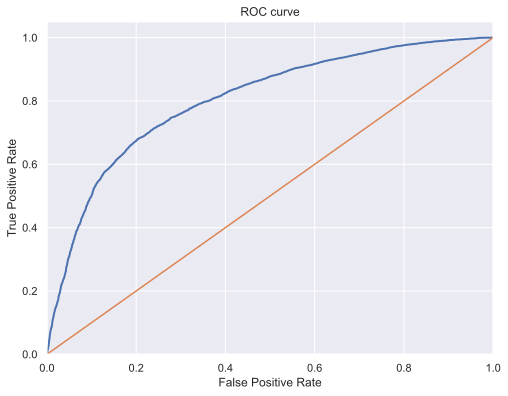

In [9]:
# Устанавливаем стиль графика и цветовую палитру
sns.set(font_scale=1)
sns.set_color_codes("muted")

# Создаем новую фигуру с заданным размером
plt.figure(figsize=(8, 6))

# Вычисляем значения FPR (False Positive Rate) и TPR (True Positive Rate) для построения кривой ROC
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

# Задаем ширину линии для графика ROC
lw = 2

# Рисуем кривую ROC
plt.plot(fpr, tpr, lw=lw, label='ROC curve')

# Рисуем диагональную линию (рандомная модель)
plt.plot([0, 1], [0, 1])

# Устанавливаем пределы для осей X и Y
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Задаем подписи для осей и заголовок графика
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# Сохраняем график в файл "ROC.png"
plt.savefig("./image/ROC.png")

# Отображаем график
plt.show()


In [10]:
# Вычисление и вывод значения ROC-AUC для обучающего набора данных
print(f"ROC AUC score for training set: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")

# Вычисление и вывод значения ROC-AUC для тестового набора данных
print(f"ROC AUC score for test set: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}")


ROC AUC score for training set: 0.8181241161955599
ROC AUC score for test set: 0.803499378245922


Матрица ошибок без нормализации
[[5214 3606]
 [1458 7222]]


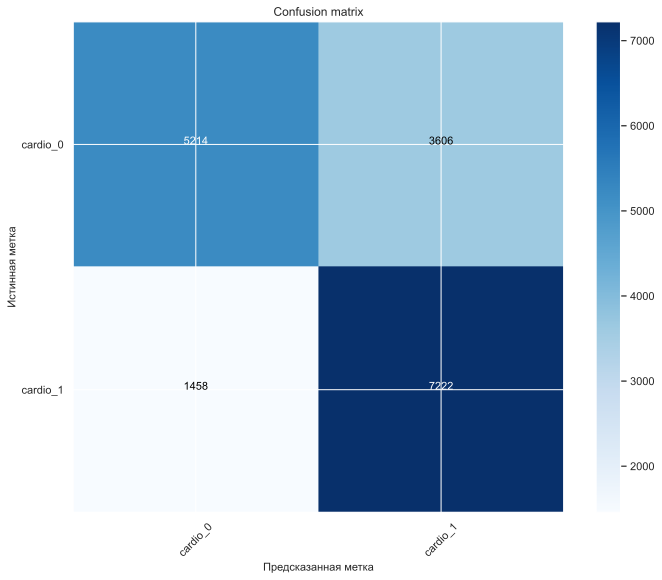

In [11]:
# Устанавливаем размер шрифта для графика
font = {'size': 11}
plt.rc('font', **font)

# Вычисление матрицы ошибок
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])

# Создание новой фигуры с заданным размером
plt.figure(figsize=(10, 8))

# Отображение матрицы ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')

# Сохранение графика матрицы ошибок в файл "conf_matrix.png"
plt.savefig("./image/conf_matrix.png")

# Отображение графика
plt.show()

In [12]:
# Извлечение значений из матрицы ошибок
TN = cnf_matrix[0][0]  # True Negative
FN = cnf_matrix[1][0]  # False Negative
TP = cnf_matrix[1][1]  # True Positive
FP = cnf_matrix[0][1]  # False Positive

# Вычисление True Positive Rate (TPR) или чувствительности
TPR = TP / (TP + FN)

# Вычисление False Positive Rate (FPR) или вероятности ложного срабатывания
FPR = FP / (FP + TN)

# Вычисление True Negative Rate (TNR) или специфичности
TNR = TN / (FP + TN)

# Вывод значений метрик
print(f"True Positive Rate (TPR): {TPR:.3f}")
print(f"False Positive Rate (FPR): {FPR:.3f}")
print(f"True Negative Rate (TNR): {TNR:.3f}")


True Positive Rate (TPR): 0.832
False Positive Rate (FPR): 0.409
True Negative Rate (TNR): 0.591


### 2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [13]:
# Создаем пустой DataFrame (metrics_df) с заданными именами столбцов
metrics_df = pd.DataFrame(columns=['model', 'F-Score', 'Precision', 'Recall', 'Roc_auc'])

# Выводим значение metrics_df
metrics_df

,model,F-Score,Precision,Recall,Roc_auc


In [14]:
# Создание словаря моделей, где ключами являются имена моделей, а значениями - экземпляры моделей с параметрами.
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}



# Цикл для перебора моделей в словаре
for modelname, model in models.items():
    # Создание пайплайна для текущей модели
    classifier = Pipeline([
        ('features', feats),  # Преобразование признаков, включая непрерывные, категориальные и базовые
        ('classifier', model)  # Модель классификации (например, логистическая регрессия, CatBoost и т. д.)
    ])



    # обучим пайплайн на всем тренировочном датасете моделью с наилучшими показателями
    classifier.fit(X_train, y_train)
    preds = classifier.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики точности, полноты и пороговые значения для кривой точности-полноты
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    # Вычисляем значение F-меры для разных порогов
    fscore = (2 * precision * recall) / (precision + recall)

    # Находим индекс порога, при котором F-мера максимальна
    ix = np.argmax(fscore)
    
    roc_auc = roc_auc_score(y_test, preds)

    
    # Создаем DataFrame, содержащий информацию о модели или настройках модели и её производительности
    data_to_append = pd.DataFrame({
        'model': [type(model).__name__],
        'F-Score': [fscore[ix]],
        'Precision': [precision[ix]],
        'Recall': [recall[ix]],
        'Roc_auc': [roc_auc]
    })
    

    # Объединяем data_to_append с существующим DataFrame metrics_df, добавляя строки в конец (axis=0)
    # и игнорируя индексы
    if data_to_append['model'].values not in metrics_df['model'].unique():
        metrics_df = pd.concat([metrics_df, data_to_append], ignore_index=True, axis=0)
    else:
        # Если нет новых моделей, просто оставляем metrics_df без изменений
        pass

    


In [15]:
# Выводим обновленный DataFrame metrics_df
metrics_df

,model,F-Score,Precision,Recall,Roc_auc
0,LogisticRegression,0.730323,0.647431,0.837558,0.784035
1,CatBoostClassifier,0.740479,0.667005,0.832143,0.803499
2,RandomForestClassifier,0.718863,0.642669,0.815553,0.771037
3,GradientBoostingClassifier,0.740248,0.697848,0.788134,0.802615


### 3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р

In [16]:
def business_threshold_calibrate(y_test, preds, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0  # Начальное значение оптимального порога
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000  # Высокое начальное значение затрат, которое будет пересчитано

    rs = []  # Список для хранения значений затрат
    n = 20  # Количество значений, которые будут проверены для порога

    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # Подбор порога для улучшения бизнес-показателя

        # Вычисление матрицы ошибок с учетом текущего порога
        cnf_matrix = confusion_matrix(y_test, preds > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        # Расчет общих затрат с учетом бизнес-метрик
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        # Если затраты с использованием текущего порога меньше, обновляем порог и затраты
        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr
            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    print(f'Расходы, если использовать МЛ алгоритм: {type(model).__name__}: {rubl_ML_}')

    return business_threshold  # Возвращаем оптимальный порог


In [17]:
# Создаем пустой DataFrame (metrics_df) с заданными именами столбцов
metrics_df = pd.DataFrame(columns=['model', 'F-Score', 'Precision', 'Recall', 'Roc_auc',\
                                   'Late_treatment', 'Early_treatment', 'Smart_treatment', 'Thresholds', \
                                  'Business_thresholds'])

# Выводим значение metrics_df
metrics_df

,model,F-Score,Precision,Recall,Roc_auc,Late_treatment,Early_treatment,Smart_treatment,Thresholds,Business_thresholds


In [18]:
# Устанавливаем стоимость теста
rubl_test = 1400

# Устанавливаем стоимость раннего лечения
rubl_early_treatment = 15000

# Устанавливаем стоимость позднего лечения
rubl_late_treatment = 20000


In [19]:
# Создание словаря моделей, где ключами являются имена моделей, а значениями - экземпляры моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20, 
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}

# Цикл для перебора моделей в словаре
for modelname, model in models.items():
    # Создание пайплайна для текущей модели
    classifier = Pipeline([
        ('features', feats),  # Преобразование признаков, включая непрерывные, категориальные и базовые
        ('classifier', model)  # Модель классификации (например, логистическая регрессия, CatBoost и т. д.)
    ])



    # обучим пайплайн на всем тренировочном датасете моделью с наилучшими показателями
    classifier.fit(X_train, y_train)
    preds = classifier.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики точности, полноты и пороговые значения для кривой точности-полноты
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    # Вычисляем значение F-меры для разных порогов
    fscore = (2 * precision * recall) / (precision + recall)

    # Находим индекс порога, при котором F-мера максимальна
    ix = np.argmax(fscore)
    
    # Вычисление матрицы ошибок с использованием текущего порога
    cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

    # Вычисление площади под кривой ROC-AUC
    roc_auc = roc_auc_score(y_test, preds)

    # Извлечение значений из матрицы ошибок
    TN = cnf_matrix[0][0]  # True Negative
    FN = cnf_matrix[1][0]  # False Negative
    TP = cnf_matrix[1][1]  # True Positive
    FP = cnf_matrix[0][1]  # False Positive

    # Вычисление затрат на лечение при разных сценариях
    
    # Затраты на лечение в случае ложноотрицательного предсказания
    expense_late_treatment = (FN + TP) * rubl_late_treatment 
    
    # Затраты на лечение в случае положительного предсказания
    expense_early_treatment = (np.sum(cnf_matrix) * rubl_test) + ((FN + TP) * rubl_early_treatment) 
    
    # Затраты с использованием модели
    expense_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment 
    
    # Вызов функции для подбора оптимального порога с учетом бизнес-метрик
    busines_tr = business_threshold_calibrate(y_test, preds, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)


    
    # Создание DataFrame для хранения информации
    data_to_append = pd.DataFrame({
        'model': [type(model).__name__],  # Имя модели
        'F-Score': [fscore[ix]],  # F-мера
        'Precision': [precision[ix]],  # Точность
        'Recall': [recall[ix]],  # Полнота
        'Roc_auc': [roc_auc],  # ROC-AUC
        'Late_treatment': [expense_late_treatment],  # Затраты на лечение в случае ложноотрицательных предсказаний
        'Early_treatment': [expense_early_treatment],  # Затраты на лечение в случае положительных предсказаний
        'Smart_treatment': [expense_ML],  # Затраты с использованием модели
        'Thresholds': [thresholds[ix]],  # Порог классификации
        'Business_thresholds': [busines_tr]  # Оптимальный порог с учетом бизнес-метрик
    })


    # Объединяем data_to_append с существующим DataFrame metrics_df, добавляя строки в конец (axis=0)
    # и игнорируя индексы
    if data_to_append['model'].values not in metrics_df['model'].unique():
        metrics_df = pd.concat([metrics_df, data_to_append], ignore_index=True, axis=0)
    else:
        # Если нет новых моделей, просто оставляем metrics_df без изменений
        pass


Расходы, если использовать МЛ алгоритм: LogisticRegression: 152712400
Расходы, если использовать МЛ алгоритм: CatBoostClassifier: 152339400
Расходы, если использовать МЛ алгоритм: RandomForestClassifier: 153132800
Расходы, если использовать МЛ алгоритм: GradientBoostingClassifier: 152333600


In [20]:
# Меняем индекс на наименование модели
metrics_df.set_index('model', inplace=True)

# Вывод данных
metrics_df

,F-Score,Precision,Recall,Roc_auc,Late_treatment,Early_treatment,Smart_treatment,Thresholds,Business_thresholds
model,,,,,,,,,
LogisticRegression,0.730323,0.647431,0.837558,0.784035,173600000,154700000,152974200,0.386937,0.315789
CatBoostClassifier,0.740479,0.667005,0.832143,0.803499,173600000,154700000,152649200,0.352783,0.263158
RandomForestClassifier,0.718863,0.642669,0.815553,0.771037,173600000,154700000,153699400,0.350000,0.210526
GradientBoostingClassifier,0.740248,0.697848,0.788134,0.802615,173600000,154700000,153122800,0.394947,0.263158


### 4. Сделать выводы о том, какая модель справилась с задачей лучше других

**По результатам анализа, можно сделать следующий вывод:**

- Модель **CatBoost Classifier** показала наилучшие результаты среди рассмотренных моделей по большинству метрик. Она демонстрирует высокий F-Score, Precision, и Roc_auc, что указывает на ее способность точно классифицировать целевую переменную. Также Recall у CatBoost Classifier является достаточно высоким, что означает способность модели правильно выявлять положительные случаи.

- Важно отметить, что у CatBoost Classifier также наблюдается относительно низкое значение Business_thresholds, что может быть важным фактором при принятии бизнес-решений. Это говорит о том, что модель может быть наиболее подходящей для оптимизации бизнес-процессов, связанных с поздним и ранним лечением.

- Хотя модель **Gradient Boosting Classifier** также продемонстрировала высокие показатели, CatBoost Classifier все равно выделяется своей производительностью. Модели **Logistic Regression** и **RandomForest Classifier** показали немного более низкие значения метрик по сравнению с CatBoost Classifier и Gradient Boosting Classifier.

- **Таким образом, на основе предоставленных данных, CatBoost Classifier можно рекомендовать в качестве наилучшей модели для решения задачи классификации, особенно если важна точность и оптимизация бизнес-показателей.**

### 5. *Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р

In [21]:
def business_threshold_calibrate(y_test, preds, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0  # Начальное значение оптимального порога
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000  # Высокое начальное значение затрат, которое будет пересчитано

    rs = []  # Список для хранения значений затрат
    n = 20  # Количество значений, которые будут проверены для порога

    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # Подбор порога для улучшения бизнес-показателя

        # Вычисление матрицы ошибок с использованием текущего порога
        cnf_matrix = confusion_matrix(y_test, preds > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        # Расчет общих затрат с учетом бизнес-метрик
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        # Если затраты с использованием текущего порога меньше, обновляем порог и затраты
        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr
            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    print(f'Расходы, если использовать МЛ алгоритм: {type(best_model).__name__}: {rubl_ML_}')

    # Настройка параметров отображения графика
    font = {'size': 10}
    plt.rc('font', **font)
    
    plt.figure(figsize=(4, 3))
    plt.title(f'Потери при МЛ решении - алгоритм: {type(best_model).__name__}', fontsize=10)
    plt.xlabel('Отсечка', fontsize=10)
    plt.ylabel('Потери', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(np.linspace(0, 1, n), rs)
    plt.show()
    
    return business_threshold  # Возвращаем оптимальный порог


In [22]:
# Создаем пустой DataFrame (metrics_df) с заданными именами столбцов
best_model_metrics_df = pd.DataFrame(columns=['model', 'F-Score', 'Precision', 'Recall', 'Roc_auc',\
                                   'Late_treatment', 'Early_treatment', 'Smart_treatment', 'Thresholds', \
                                  'Business_thresholds'])

# Выводим значение metrics_df
best_model_metrics_df

,model,F-Score,Precision,Recall,Roc_auc,Late_treatment,Early_treatment,Smart_treatment,Thresholds,Business_thresholds


CV score for LogisticRegression is 0.7864573689384385+-0.004422021036885763
CV score for CatBoostClassifier is 0.8034180223226074+-0.0031687982978565636
CV score for RandomForestClassifier is 0.7743796633622809+-0.003611330100912611
CV score for GradientBoostingClassifier is 0.8023336401314394+-0.003067762759094604
Расходы, если использовать МЛ алгоритм: CatBoostClassifier: 152339400


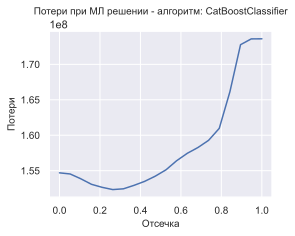

In [23]:
# Создание словаря моделей, где ключами являются имена моделей, а значениями - экземпляры моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=42),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20, 
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=42),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42)  # Градиентный бустинг
}

best_score = 0  # Переменная для отслеживания наилучшей оценки производительности
best_model = None  # Переменная для хранения лучшей модели

# Цикл для перебора моделей в словаре
for modelname, model in models.items():
    # Создание пайплайна для текущей модели
    classifier = Pipeline([
        ('features', feats),  # Преобразование признаков, включая непрерывные, категориальные и базовые
        ('classifier', model)  # Модель классификации (например, логистическая регрессия, CatBoost и т. д.)
    ])

    # Запуск кросс-валидации с оценкой производительности по метрике ROC-AUC
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)  # Среднее значение оценок ROC-AUC
    cv_score_std = np.std(cv_scores)  # Стандартное отклонение оценок ROC-AUC
    print(f'CV score for {modelname} is {cv_score}+-{cv_score_std}')  # Вывод оценки производительности

    # Если текущая модель показывает лучшую оценку, обновляем лучшую модель и лучшую оценку
    if cv_score > best_score:
        best_score = cv_score
        best_model = model

# Создание пайплайна с лучшей моделью
classifier = Pipeline([
        ('features', feats),
        ('classifier', best_model)
    ])

# Обучение пайплайна на всем тренировочном датасете моделью с наилучшими показателями
classifier.fit(X_train, y_train)
preds = classifier.predict_proba(X_test)[:, 1]

# Вычисляем метрики точности, полноты и пороговые значения для кривой точности-полноты
precision, recall, thresholds = precision_recall_curve(y_test, preds)

# Вычисляем значение F-меры для разных порогов
fscore = (2 * precision * recall) / (precision + recall)

# Находим индекс порога, при котором F-мера максимальна
ix = np.argmax(fscore)

# Вычисление матрицы ошибок
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, preds)

# Извлечение элементов матрицы ошибок
TN = cnf_matrix[0][0]  # True Negative
FN = cnf_matrix[1][0]  # False Negative
TP = cnf_matrix[1][1]  # True Positive
FP = cnf_matrix[0][1]  # False Positive

# Расчет затрат на лечение при разных сценариях
# Затраты при позднем лечении
expense_late_treatment = (FN + TP) * rubl_late_treatment  

# Затраты при раннем лечении
expense_early_treatment = (np.sum(cnf_matrix) * rubl_test) + ((FN + TP) * rubl_early_treatment) 

# Затраты с использованием модели
expense_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment  

# Вызов функции для калибровки бизнес-порога
busines_tr = business_threshold_calibrate(y_test, preds, thresholds[ix],
                                          rubl_test=1400, rubl_early_treatment=15000, rubl_late_treatment=20000)




# Создание DataFrame для текущей лучшей модели
data_to_append_ = pd.DataFrame({
    'model': [type(best_model).__name__],  # Имя модели
    'F-Score': [fscore[ix]],  # F-мера
    'Precision': [precision[ix]],  # Точность
    'Recall': [recall[ix]],  # Полнота
    'Roc_auc': [roc_auc],  # ROC-AUC
    'Late_treatment': [expense_late_treatment],  # Затраты при позднем лечении
    'Early_treatment': [expense_early_treatment],  # Затраты при раннем лечении
    'Smart_treatment': [expense_ML],  # Затраты с использованием модели
    'Thresholds': [thresholds[ix]],  # Оптимальный порог модели
    'Business_thresholds': [busines_tr]  # Бизнес-порог
})

# Объединение созданного DataFrame с общим DataFrame метрик для всех моделей
best_model_metrics_df = pd.concat([best_model_metrics_df, data_to_append_], ignore_index=True, axis=0)


In [24]:
# Устанавливаем индекс для DataFrame, чтобы удобнее было обращаться к данным по моделям
best_model_metrics_df.set_index('model', inplace=True)

# Выводим DataFrame с установленным индексом
best_model_metrics_df


,F-Score,Precision,Recall,Roc_auc,Late_treatment,Early_treatment,Smart_treatment,Thresholds,Business_thresholds
model,,,,,,,,,
CatBoostClassifier,0.740479,0.667005,0.832143,0.803499,173600000,154700000,152649200,0.352783,0.263158
